# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Git import *

In [3]:
# %run "Git.ipynb".ipynb

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [7]:

Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [14]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [15]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_62184\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [16]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [324]:
holding=Binance.get_inventory()

In [326]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,2316.83,2199.49,1.00,-131.89,14.54,-117.35,-5.06
BTCUSDT,601.02,1045.10,0.48,3.54,444.08,447.62,19.32
SOLUSDT,281.20,324.57,0.15,0.00,43.37,43.37,1.87
ETHUSDT,250.75,259.44,0.12,0.00,8.69,8.69,0.38
JASMYUSDT,387.46,249.59,0.11,0.00,-137.87,-137.87,-5.95
TRXUSDT,76.87,153.77,0.07,-10.72,76.90,66.18,2.86
OMUSDT,526.32,151.43,0.07,0.00,-374.89,-374.89,-16.18
BBUSDT,60.18,14.30,0.01,-39.73,-45.88,-85.61,-3.70
BNBUSDT,1.14,1.28,0.00,-10.61,0.14,-10.47,-0.45
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.66


In [20]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

97

In [21]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [22]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [23]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [24]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [25]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [26]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [28]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 43a86331f793e5ca15e86889397e54a0fef80197)
✅ File pushed/updated successfully!


In [29]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [30]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [31]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [32]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 50db58677d2a2aeda84946b46035cce306040542)
✅ File pushed/updated successfully!


In [33]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [34]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [35]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [36]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [37]:
# pnl_history['Total']

In [38]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [39]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [40]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [41]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [42]:
pnl_history['Total']

2024-09-23   -242.846960
2024-09-24   -351.229838
2024-09-25   -362.331965
2024-09-26   -276.632747
2024-09-27   -260.113627
                 ...    
2025-07-15   -280.678988
2025-07-16   -233.334843
2025-07-17   -208.279235
2025-07-18   -217.204015
2025-07-19    -78.621922
Name: Total, Length: 300, dtype: float64

<Axes: >

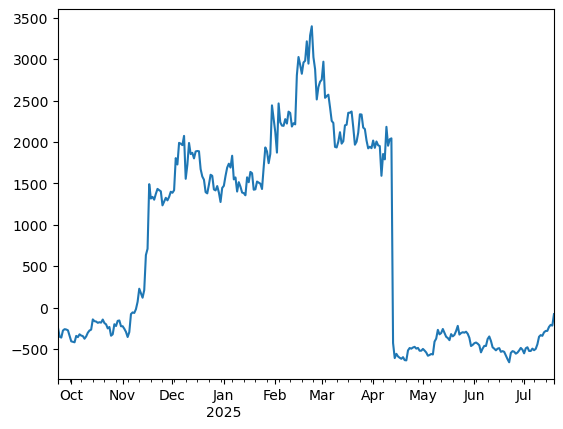

In [43]:
pnl_history['Total'].plot()

In [44]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-07-15      1.309020
2025-07-16     47.344145
2025-07-17     25.055608
2025-07-18     -8.924780
2025-07-19    138.582093
Name: Total, Length: 300, dtype: float64

In [45]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-374.7983250244094, -1142.8435479265506)

In [46]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [47]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [48]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [49]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [50]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [51]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [52]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

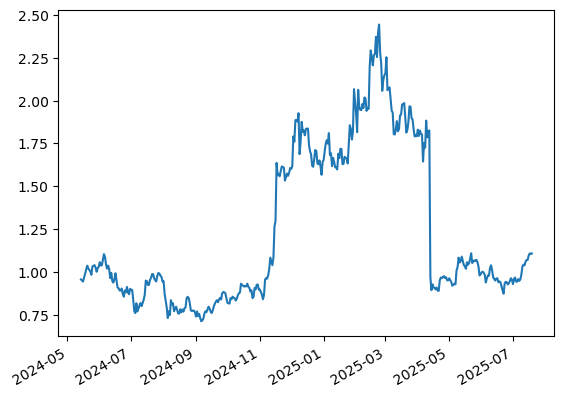

In [53]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

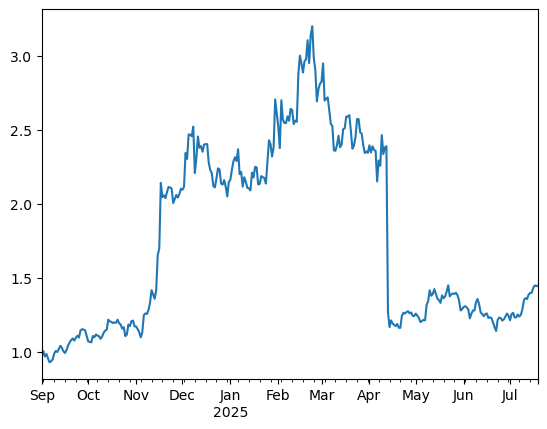

In [54]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [56]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [59]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [60]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [63]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.2749
XRPUSDT,0.1821
TRXUSDT,0.1784
AAVEUSDT,0.1346
WBTCUSDT,0.0673
OMUSDT,0.0577
BTCUSDT,0.0492
PEPEUSDT,0.0440
SUIUSDT,0.0117
LDOUSDT,0.0000


In [64]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
USDCUSDT,0.955181
WBTCUSDT,0.018012
BNBUSDT,0.010986
TRXUSDT,0.007248
XRPUSDT,0.006319
OMUSDT,0.001764
PEPEUSDT,0.000490


In [65]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

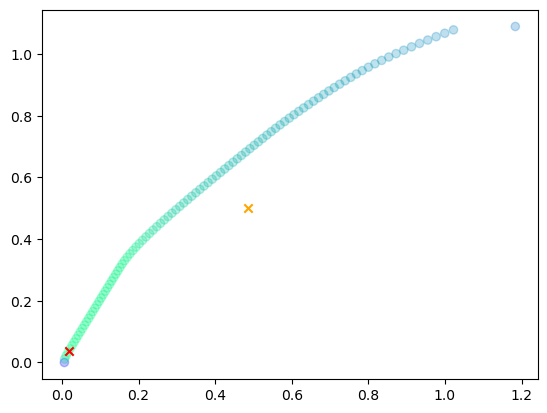

In [66]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [67]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [68]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1047.710197,0.475439,0.0105,0.464939
SOLUSDT,326.093402,0.147978,0.0000,0.147978
ETHUSDT,261.054825,0.118464,0.0000,0.118464
JASMYUSDT,255.858036,0.116106,0.0000,0.116106
TRXUSDT,154.207879,0.069978,0.0027,0.067278
OMUSDT,143.048811,0.064914,0.0006,0.064314
BBUSDT,14.411830,0.006540,0.0000,0.006540
BNBUSDT,1.284088,0.000583,0.0038,-0.003217
PEPEUSDT,0.000003,0.000000,0.0006,-0.000600
PAXGUSDT,0.000000,0.000000,0.0852,-0.085200


### Current results

In [70]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [71]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.685723
TRXUSDT,0.314277


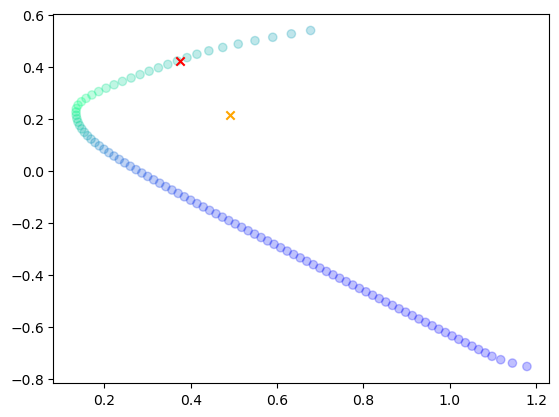

In [72]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [73]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1047.710197,0.475439,0.685723,-0.210284
SOLUSDT,326.093402,0.147978,0.000000,0.147978
ETHUSDT,261.054825,0.118464,0.000000,0.118464
JASMYUSDT,255.858036,0.116106,0.000000,0.116106
TRXUSDT,154.207879,0.069978,0.314277,-0.244299
OMUSDT,143.048811,0.064914,0.000000,0.064914
BBUSDT,14.411830,0.006540,0.000000,0.006540
BNBUSDT,1.284088,0.000583,0.000000,0.000583
PEPEUSDT,0.000003,0.000000,0.000000,0.000000


# Risk Reward Analysis

In [75]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [76]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

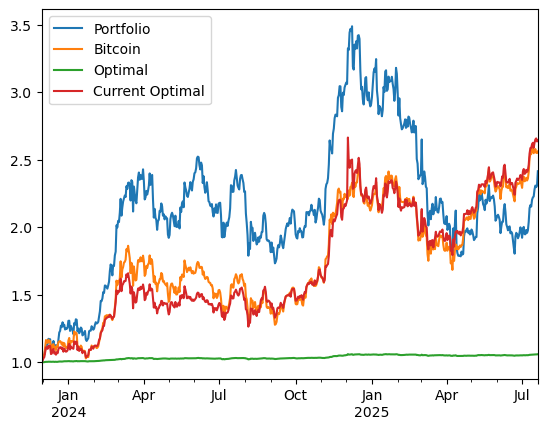

In [77]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [78]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

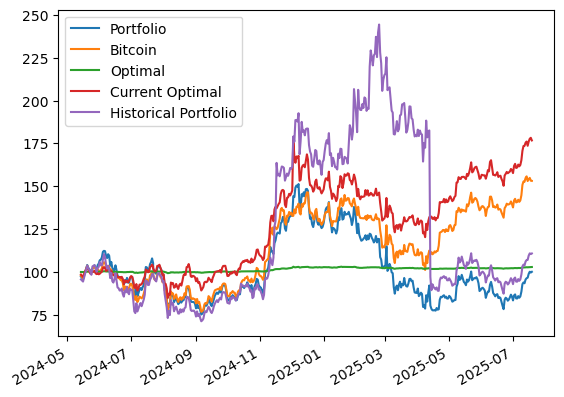

In [79]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [80]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-07-10,92.854330,150.798692,102.509665,170.668818,103.187513
2025-07-11,93.828993,152.758670,102.583330,173.452450,104.252794
2025-07-12,93.348937,152.618673,102.585510,173.578452,103.780180
2025-07-13,95.527733,154.769687,102.638719,175.364222,106.035101
2025-07-14,96.311891,155.747224,102.707457,176.069107,106.911464
2025-07-15,96.606180,153.016207,102.672147,173.584971,107.015321
2025-07-16,98.878200,154.145558,102.727882,176.091016,109.508251
2025-07-17,100.106939,154.854851,102.825408,177.708886,110.825050
2025-07-18,99.607048,153.218498,102.836487,178.249080,110.373211
2025-07-19,100.042142,153.108227,102.840704,176.734449,110.739058


## Volatilities

In [82]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.016202
 dtype: float64,
 0.016215565764732345)

In [83]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.491476
 dtype: float64,
 0.4914763361565573)

In [84]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.489068
Bitcoin            0.413845
Optimal            0.016216
Current Optimal    0.374290
dtype: float64

In [85]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.5467757423168855

In [86]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

4.180814301870766

In [87]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.4414902099698032

## Risk Contribution

In [89]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
WBTCUSDT,2.8200,0.3518,0.2074,0.1444
BNBUSDT,1.7893,0.2253,0.0903,0.1350
XRPUSDT,1.4683,0.1907,0.0737,0.1170
TRXUSDT,0.8205,0.1392,0.0711,0.0681
PEPEUSDT,0.0833,0.0217,0.0013,0.0204
USDCUSDT,-0.0422,-0.0066,0.1227,-0.1292
OMUSDT,-2.2225,0.0778,0.0345,0.0433
Portfolio,4.7167,1.0000,0.6010,0.3990


In [90]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,44.432829,0.597516,0.516743,0.080773
TRXUSDT,25.372173,0.402484,0.321711,0.080773
Portfolio,69.805003,1.000000,0.838454,0.161546


In [91]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
test=current_risk.perf_contrib(current_weights)

# Value At Risk

## Historical

### Optimal Weights

In [95]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.0034863602379990124, -0.0037696165329149296)

### Current Weights

In [97]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.08475246242259445, -0.10263358834832781)

In [98]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [99]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.018367
SOLUSDT     -0.013359
ETHUSDT     -0.009001
JASMYUSDT   -0.020248
TRXUSDT     -0.013253
OMUSDT      -0.009579
BBUSDT      -0.002209
BNBUSDT     -0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.086017
Name: 2024-12-09 00:00:00, dtype: float64

In [100]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.024624
SOLUSDT     -0.019161
ETHUSDT     -0.012144
JASMYUSDT   -0.015209
TRXUSDT     -0.003697
OMUSDT      -0.026120
BBUSDT      -0.001680
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.102634
dtype: float64

## Parametric

### Optimal Weights

In [103]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.0023763285930286236, -0.0029432384115934875)

### Current Weights

In [105]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.0720239606407006, -0.08920638674916374)

## Multivariate

### Optimal Weights

In [108]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0022816629879945393, -0.0026540970960009687)

### Current Weights

In [110]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07134785492205999, -0.08176600369748366)

In [111]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.023240
SOLUSDT     -0.013299
ETHUSDT     -0.008905
JASMYUSDT   -0.014657
TRXUSDT     -0.002307
OMUSDT      -0.007136
BBUSDT      -0.001207
Portfolio   -0.070750
dtype: float64

In [112]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.023239
SOLUSDT     -0.014194
ETHUSDT     -0.009117
JASMYUSDT   -0.014011
TRXUSDT     -0.001907
OMUSDT      -0.008017
BBUSDT      -0.001282
Portfolio   -0.071767
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [116]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0022550264788838833, -0.002621000729809177)

### Current Weights

In [118]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07041161961215511, -0.08063156687999039)

In [119]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [122]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0023155535997844232, -0.0026372854408909423)

### Current Weights

In [124]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07248538463427806, -0.08309898303868035)

In [125]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [128]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.003985957134434535, -0.004766560060681809)

### Current Weights

In [130]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.09274567481989404, -0.1128009845900026)

In [131]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [134]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [135]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.002272495957857204, -0.0026313652831253713)

### Current Weights

In [137]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07351208810552637, -0.08357001764627496)

In [138]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [139]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.026302,-0.023709,-0.017163,-0.023240,-0.024927
SOLUSDT,-0.009491,-0.012836,-0.009402,-0.013299,-0.013355
ETHUSDT,-0.002717,-0.008977,-0.006236,-0.008905,-0.009086
JASMYUSDT,-0.012803,-0.014431,-0.010939,-0.014657,-0.015758
TRXUSDT,-0.000457,-0.002181,-0.001818,-0.002307,-0.002462
OMUSDT,-0.008794,-0.007806,-0.005544,-0.007136,-0.006230
BBUSDT,-0.000284,-0.001282,-0.000852,-0.001207,-0.001269
Portfolio,-0.060847,-0.071222,-0.051956,-0.070750,-0.073086


In [140]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.027346,-0.024418,-0.017301,-0.023239,-0.024142
SOLUSDT,-0.010642,-0.012708,-0.009823,-0.014194,-0.013557
ETHUSDT,-0.004239,-0.009188,-0.006145,-0.009117,-0.009081
JASMYUSDT,-0.012200,-0.014568,-0.010535,-0.014011,-0.016271
TRXUSDT,0.000481,-0.001814,-0.001555,-0.001907,-0.002820
OMUSDT,-0.007212,-0.008075,-0.006336,-0.008017,-0.006698
BBUSDT,-0.000467,-0.001318,-0.000887,-0.001282,-0.001394
Portfolio,-0.061624,-0.072090,-0.052582,-0.071767,-0.073963


## VaR Violation

In [142]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.001820,-0.001962,-0.001810,-0.000340
2024-01-15,-0.001820,-0.001934,-0.001797,0.000729
2024-01-16,-0.001820,-0.001898,-0.001720,0.000086
2024-01-17,-0.001820,-0.001895,-0.001684,0.000068
2024-01-18,-0.001820,-0.001935,-0.001808,-0.000747
...,...,...,...,...
2025-07-16,-0.000996,-0.001610,-0.001465,0.000543
2025-07-17,-0.000996,-0.001612,-0.001341,0.000949
2025-07-18,-0.000996,-0.001611,-0.001380,0.000108
2025-07-19,-0.000996,-0.001611,-0.001350,0.000041


In [143]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.026144,-0.079632,-0.072678,-0.016873
2024-05-29,-0.019516,-0.077311,-0.067833,-0.009883
2024-05-30,-0.019516,-0.065195,-0.058425,0.028443
2024-05-31,-0.019516,-0.063789,-0.055337,0.008025
2024-06-01,-0.019516,-0.062538,-0.054586,0.019012
...,...,...,...,...
2025-07-16,-0.024605,-0.044996,-0.033229,0.023518
2025-07-17,-0.024605,-0.042488,-0.033080,0.012427
2025-07-18,-0.024605,-0.043430,-0.033522,-0.004994
2025-07-19,-0.010093,-0.036939,-0.026389,0.004368


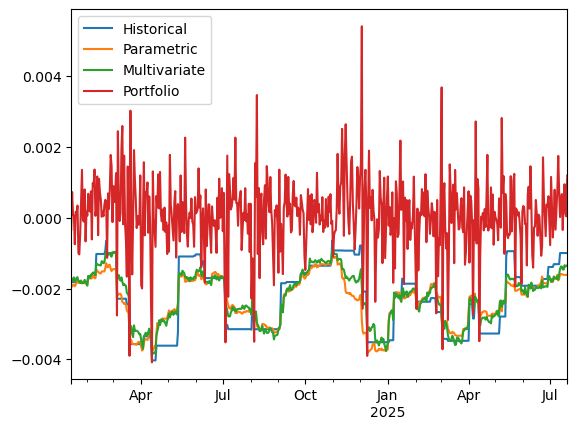

In [144]:
var_data.plot()
plt.show()

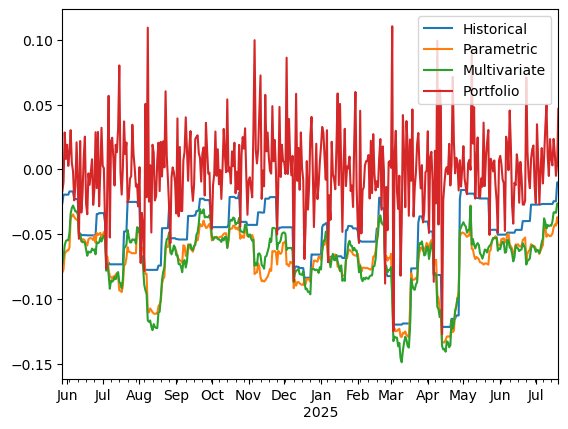

In [145]:
current_var_data.plot()
plt.show()


In [146]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.030686,0.019856,0.028881
Kupiec Stat,5.01663,13.606572,6.095194
P-value,0.025105,0.000225,0.013555


In [147]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064439,0.019093,0.011933
Kupiec Stat,1.692128,10.91366,18.203745
P-value,0.193321,0.000955,0.00002


# Principal Component Analysis

## Historical PCA

In [150]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77736002, 0.09348076, 0.05416041, 0.03997821, 0.03502061])

In [151]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.017940
ADAUSDT      0.018726
ALGOUSDT     0.020081
APTUSDT      0.017827
ARBUSDT      0.020588
ATOMUSDT     0.017062
AVAXUSDT     0.019776
BCHUSDT      0.014845
BNBUSDT      0.008685
BONKUSDT     0.025327
BTCUSDT      0.009693
CFXUSDT      0.022892
CRVUSDT      0.020893
DOGEUSDT     0.019454
DOTUSDT      0.017699
ENSUSDT      0.021179
ETCUSDT      0.016320
ETHUSDT      0.014546
FDUSDUSDT    0.000068
FETUSDT      0.023096
FILUSDT      0.019465
FLOKIUSDT    0.024621
GRTUSDT      0.021726
HBARUSDT     0.018875
ICPUSDT      0.017809
IMXUSDT      0.020952
INJUSDT      0.021675
IOTAUSDT     0.020832
JASMYUSDT    0.021877
LDOUSDT      0.021948
LINKUSDT     0.018149
LTCUSDT      0.013377
MKRUSDT      0.013984
NEARUSDT     0.021896
OMUSDT       0.015006
OPUSDT       0.021027
PAXGUSDT     0.000047
PEPEUSDT     0.025466
QNTUSDT      0.014892
RAYUSDT      0.021481
SEIUSDT      0.021361
SHIBUSDT     0.018417
SOLUSDT      0.016746
STXUSDT      0.020927
SUIUSDT      0.018940
THETAUSDT 

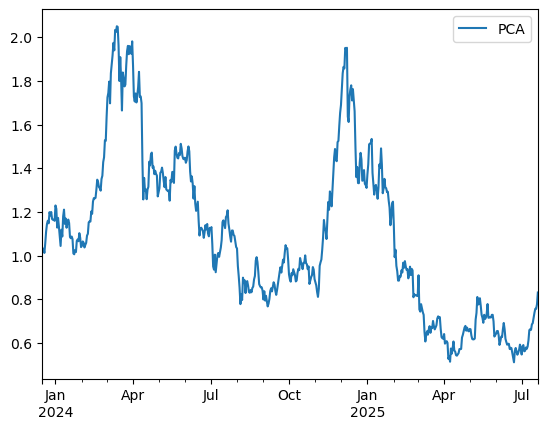

In [152]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

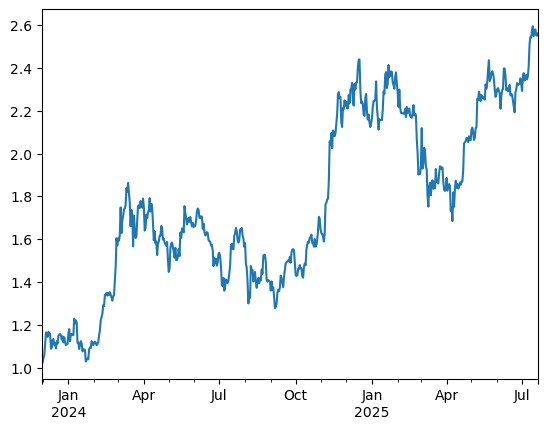

In [153]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [154]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
WBETHUSDT    0.500421
ETHUSDT      0.500914
DOTUSDT      0.526214
ETCUSDT      0.536219
ATOMUSDT     0.546609
AVAXUSDT     0.571996
FILUSDT      0.592701
GRTUSDT      0.608603
IOTAUSDT     0.625265
WBTCUSDT     0.633848
LINKUSDT     0.633972
BTCUSDT      0.634145
ARBUSDT      0.639013
VETUSDT      0.646094
SOLUSDT      0.679325
THETAUSDT    0.683002
ALGOUSDT     0.684530
IMXUSDT      0.716311
DOGEUSDT     0.719184
dtype: float64

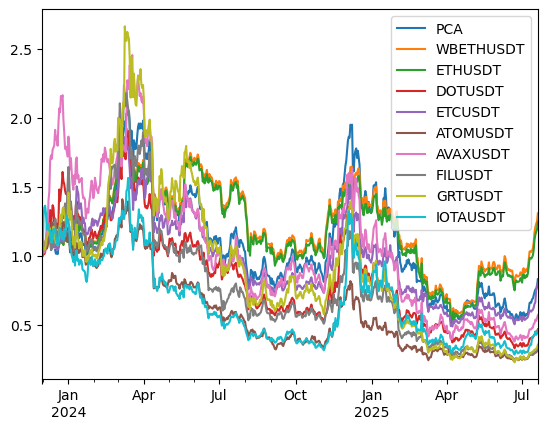

In [155]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

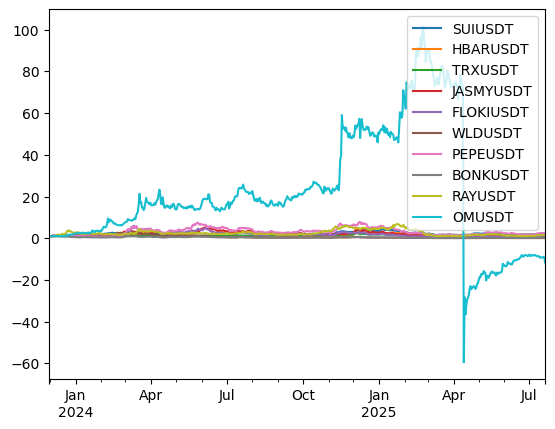

In [156]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [158]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.52125951, 0.30525173, 0.07003243, 0.06059371, 0.04286262])

In [159]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.050285
SOLUSDT      0.092062
ETHUSDT      0.080226
JASMYUSDT    0.140626
TRXUSDT      0.035494
OMUSDT       0.246828
BBUSDT       0.165673
BNBUSDT      0.050868
PEPEUSDT     0.137149
PAXGUSDT     0.000790
Name: PC1, dtype: float64

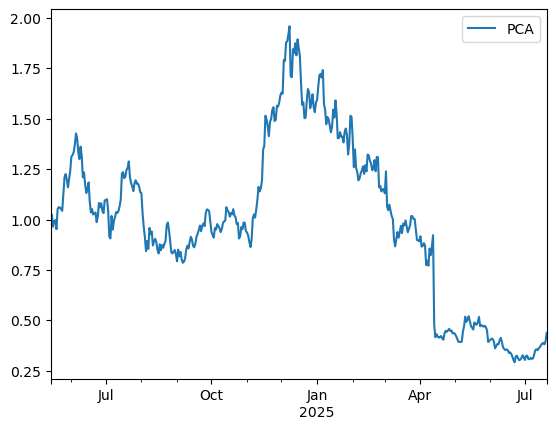

In [160]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()
plt.show()

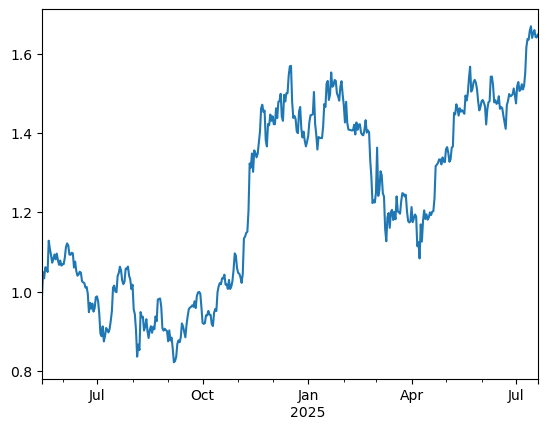

In [161]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [162]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.727643
SOLUSDT      0.764778
BTCUSDT      0.778772
BNBUSDT      0.785832
JASMYUSDT    0.979387
PEPEUSDT     1.010766
PAXGUSDT     1.038386
BBUSDT       1.039668
TRXUSDT      1.157489
dtype: float64

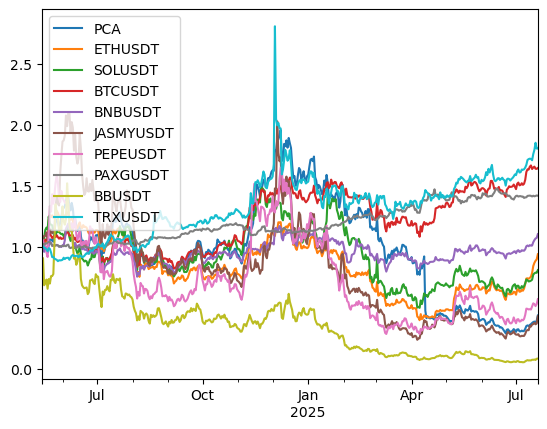

In [163]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [165]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.918786
BBUSDT       1.616496
JASMYUSDT    1.457411
SOLUSDT      1.277539
ETHUSDT      1.090173
BTCUSDT      1.000000
OMUSDT       0.993763
BNBUSDT      0.659882
TRXUSDT      0.330349
PAXGUSDT     0.027347
Name: BTCUSDT, dtype: float64

In [166]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.598055
PEPEUSDT     2.510546
JASMYUSDT    2.360265
OMUSDT       2.185495
ETHUSDT      1.537140
SOLUSDT      1.442225
BTCUSDT      1.000000
BNBUSDT      0.695645
TRXUSDT      0.517543
PAXGUSDT    -0.082951
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [168]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [169]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
ETHUSDT,0.258134
BNBUSDT,0.178342
BTCUSDT,0.157291
JASMYUSDT,0.146689
TRXUSDT,0.144615
PEPEUSDT,0.132660
BBUSDT,0.121649
OMUSDT,0.065594
SOLUSDT,0.034263
PAXGUSDT,-0.695318


### Regression to PCA

In [171]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.6647627209152764

In [172]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.409469
BNBUSDT      1.271768
PCA          1.000000
ETHUSDT      0.995769
SOLUSDT      0.786086
JASMYUSDT    0.504804
PEPEUSDT     0.498302
BBUSDT       0.445076
TRXUSDT      0.320369
PAXGUSDT     0.148167
OMUSDT       0.119467
dtype: float64

In [173]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      2.346850
BTCUSDT      1.976855
TRXUSDT      1.278329
ETHUSDT      1.073292
SOLUSDT      1.026255
PCA          1.000000
PEPEUSDT     0.690061
JASMYUSDT    0.575444
BBUSDT       0.487979
OMUSDT       0.442127
PAXGUSDT    -2.858496
dtype: float64

### Correlation Matrix

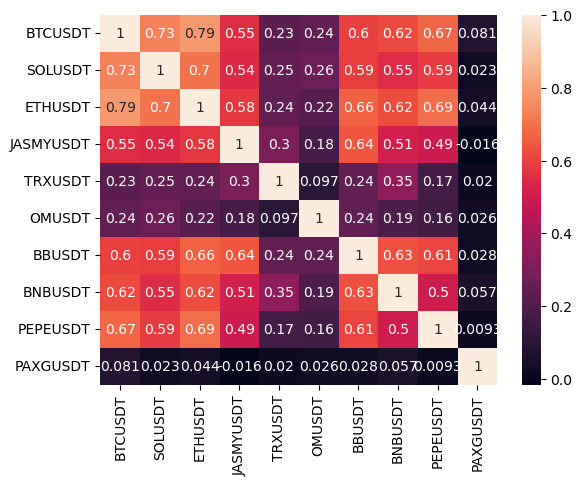

In [175]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

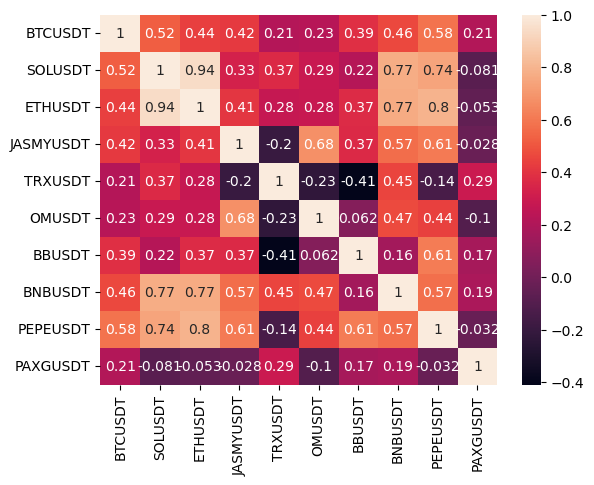

In [176]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [177]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [178]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

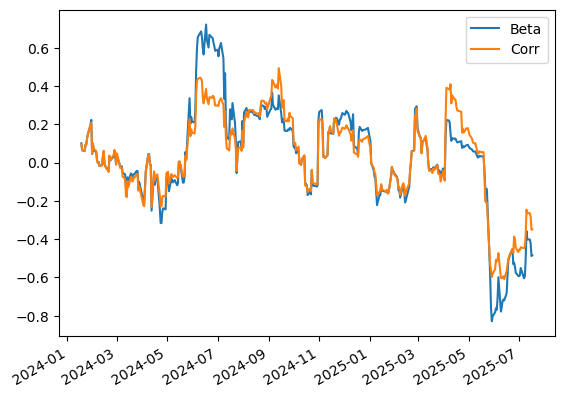

In [179]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [181]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,SOLUSDT,ETHUSDT,JASMYUSDT,TRXUSDT,OMUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483880,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.000000,0.000000,0.150876,0.222957,0.626168,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.932278,0.000000,0.000000,0.000000,0.000000,0.067722
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.223616,0.000000,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.260704,0.086231,0.000000,0.000000,0.238042,0.019283,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.453782,0.000000,0.000000,0.000000,0.000000,0.546218
2024-09-02,0.000000,0.000000,0.000000,0.000000,0.564814,0.435186,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.000000,0.166022,0.000000,0.526886,0.176734,0.000000,0.000000,0.130357,0.000000


In [182]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-12-12,0.172678,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.008852,0.146002,0.000000
2025-01-11,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.364922,0.000000
2025-02-10,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2025-03-12,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.069586,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2025-04-11,0.000000,0.000000,0.0,0.000000,0.000000,0.029045,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2025-05-11,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.100879,0.0,0.000000,0.000000,0.000000
2025-06-10,0.996854,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2025-07-10,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.256356,0.000000,0.060956,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2025-07-20,0.215477,0.000003,0.0,0.000004,0.000002,0.000001,0.000006,0.000000,0.000004,0.010979,...,0.54062,0.0,0.0,0.0,0.000003,0.000007,0.0,0.042569,0.000000,0.076982


In [183]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

TRXUSDT     0.540620
AAVEUSDT    0.215477
XTZUSDT     0.076982
SUIUSDT     0.064858
XLMUSDT     0.042569
SEIUSDT     0.039401
Name: 2025-07-20 00:00:00, dtype: float64

In [184]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
